# Download Data

In [1]:
import glob
import json
import os
import re
import zipfile
from urllib.request import urlretrieve

import pandas as pd
import requests

In [2]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareairline/"

To send a GET request to list the available files:

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(
    response.text
)  # this contains all the articles data, feel free to check it out
files = data["files"]  # this is just the data about the files, which is what we want
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

To get the file named `data.zip`:

In [4]:
%%time
files_to_dl = ["data.zip"]  # feel free to add other files here
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 5.38 s, sys: 7.04 s, total: 12.4 s
Wall time: 3min 26s


In [5]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), "r") as f:
    f.extractall(output_directory)

CPU times: user 19 s, sys: 3.36 s, total: 22.3 s
Wall time: 24 s


# Combine Data CSVs

To combine all these files using python:

In [6]:
%%time
import pandas as pd

files = glob.glob("figshareairline/*.csv")
try:
    files.remove(os.path.join("figshareairline", "observed_daily_rainfall_SYD.csv"))
except:
    pass
try:
    files.remove(os.path.join("figshareairline", "combined_data.csv"))
except:
    pass

df = pd.concat(
    (
        pd.read_csv(file, index_col=False)
        .assign(
            file_name=re.findall("[ \w-]+\.", file)[0],
            model=lambda x: x.file_name.str.split("_", expand=True)[0],
        )
        .drop(columns="file_name")
        for file in files
    )
)
df.to_csv("figshareairline/combined_data.csv")

CPU times: user 12min 21s, sys: 1min 18s, total: 13min 39s
Wall time: 14min 21s


In [7]:
%%sh
du -sh figshareairline/combined_data.csv

6.0G	figshareairline/combined_data.csv


In [8]:
df.shape

(62467843, 7)

In [9]:
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


### Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes | 12min 58s | 13min 22s |
| Harry | macOS | 16GB | Intel i5 | Yes | 12min 12s | 15min 22s  |
| Brandon | macOS | 16GB | Apple M1 | Yes | 13min 20s | 15min 3s |
| Anthea | Windows10Pro | 8GB | Intel | No | 47min23s | 63min15s |

### Summary:
> 1. The combined CSV file is 6.1GB. It was expected that it would took much longer time to read the file and save into in-memory using pandas methods.  
> 2. The run time varies a lot. Among all observations, the processing time increases when the computer has less RAM. It was also expected that the computer would slow down when it has used up all of the available RAM memory. 

# Load the combined CSV to memory and perform a simple EDA

Let's first load the combined CSV to memory.

In [10]:
%%time
df = pd.read_csv("figshareairline/combined_data.csv", index_col=0)
print(df["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 1min 4s, sys: 26.3 s, total: 1min 30s
Wall time: 1min 42s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes | 1min 19s | 1min 26s |
| Harry | macOS | 16GB | Intel i5 | Yes | 1min 33s | 1min 41s    |
| Brandon | macOS | 16GB | Apple M1 | Yes | 1min 6s | 1min 26s   |
| Anthea | Windows10Pro | 8GB | Intel | No | 4min 34s | 7min 51s |

In [11]:
df.describe()

,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
count,5.924854e+07,6.246784e+07,5.924854e+07,6.246784e+07,5.924854e+07
mean,-3.310482e+01,-3.197757e+01,1.469059e+02,1.482150e+02,1.901170e+00
std,1.963549e+00,1.992067e+00,3.793784e+00,3.809994e+00,5.585735e+00
min,-3.646739e+01,-3.600000e+01,1.406250e+02,1.412500e+02,-3.807373e-12
25%,-3.486911e+01,-3.366221e+01,1.434375e+02,1.450000e+02,3.838413e-06
50%,-3.300000e+01,-3.204188e+01,1.468750e+02,1.481250e+02,6.154947e-02
75%,-3.140170e+01,-3.015707e+01,1.501875e+02,1.513125e+02,1.020918e+00
max,-2.990000e+01,-2.790606e+01,1.537500e+02,1.556250e+02,4.329395e+02


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62467843 entries, 0 to 3541152
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
 6   model          object 
dtypes: float64(5), object(2)
memory usage: 3.7+ GB


### Loading only columns we need
It takes 3.7GB of memery! To reduce the use of memory, let's try loading only the columns (e.g. "time", "rain(mm/day)" and "model") we need.

In [13]:
%%time
use_cols = ["time", "rain (mm/day)", "model"]
df_columns = pd.read_csv("figshareairline/combined_data.csv", usecols=use_cols)
print(df_columns["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 51.9 s, sys: 11.2 s, total: 1min 3s
Wall time: 1min 5s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes | 1min 19s | 1min 26s |
| Harry | macOS | 16GB | Intel i5 | Yes | 1min 9s | 1min 15s |
| Brandon | macOS | 16GB | Apple M1 | Yes | 55.4s | 1min 5s |
| Anthea | Windows10Pro | 8GB | Intel | No | 3min 11s | 4min 58s |

In [14]:
df_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   rain (mm/day)  float64
 2   model          object 
dtypes: float64(1), object(2)
memory usage: 1.4+ GB


The memory usage greatly reduced to 1.4GB by just loading the columns we need. The runtime also reduced by ~20% in general.

### Changing dtype
The dtype for lat_min, lat_max, lon_min, lon_max and rain (mm/day) are all float64. To reduce the use of memeory, we can change the dtype to float32 as this is good enough for the stored values. The memory usage will be greatly reduced from 2998MB to 1749MB.

In [15]:
print(
    f"Memory usage with float64: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB"
)
print(
    f"Memory usage with float32: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB"
)

Memory usage with float64: 2998.46 MB
Memory usage with float32: 1749.10 MB


In [16]:
%%time
dtypes = {"lat_min": "float32",
          "lat_max": "float32",
          "lon_min": "float32",
          "lon_max": "float32",
          "rain (mm/day)": "float32"}

df_dtype = pd.read_csv("figshareairline/combined_data.csv", index_col=0, dtype=dtypes)
print(df_dtype["model"].value_counts())

MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64
CPU times: user 1min 3s, sys: 18.9 s, total: 1min 22s
Wall time: 1min 30s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes |  1min 24s | 1min 24s |
| Harry | macOS | 16GB | Intel i5 | Yes | 1min 26s | 1min 33s |
| Brandon | macOS | 16GB | Apple M1 | Yes | 1min 2s | 1min 10s |
| Anthea | Windows10Pro | 8GB | Intel | No | 3min 42s | 5min 43s |

### Loading the data in chunks

In [17]:
%%time
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("figshareairline/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
AWI-ESM-1-1-LR       966420
BCC-CSM2-MR         3035340
BCC-ESM1             551880
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
CanESM5              551880
EC-Earth3-Veg-LR    3037320
FGOALS-f3-L         3219300
FGOALS-g3           1287720
GFDL-CM4            3219300
GFDL-ESM4           3219300
INM-CM4-8           1609650
INM-CM5-0           1609650
KIOST-ESM           1287720
MIROC6              2070900
MPI-ESM-1-2-HAM      966420
MPI-ESM1-2-HR       5154240
MPI-ESM1-2-LR        966420
MRI-ESM2-0          3037320
NESM3                966420
NorESM2-LM           919800
NorESM2-MM          3541230
SAM0-UNICON         3541153
TaiESM1             3541230
dtype: int64
CPU times: user 1min 5s, sys: 12.8 s, total: 1min 18s
Wall time: 1min 19s


Run Times:

| Team Member | Operating System | RAM | Processor | Is SSD | CPU times | Wall time |
| --- | --- | --- | --- | --- | --- | --- |
| Alex | Windows 10 Home | 16GB | AMD | Yes |  1min 1s | 1min 1s |
| Harry | macOS | 16GB | Intel i5 | Yes | 1min 23s | 1min 27s |
| Brandon | macOS | 16GB | Apple M1 | Yes | 53.3s | 54.8s |
| Anthea | Windows10Pro | 8GB | Intel | No | 53.3s | 54.8s |

Running the data in chunks also improves the runtime. We see great improvement for those with less RAM.

### EDA

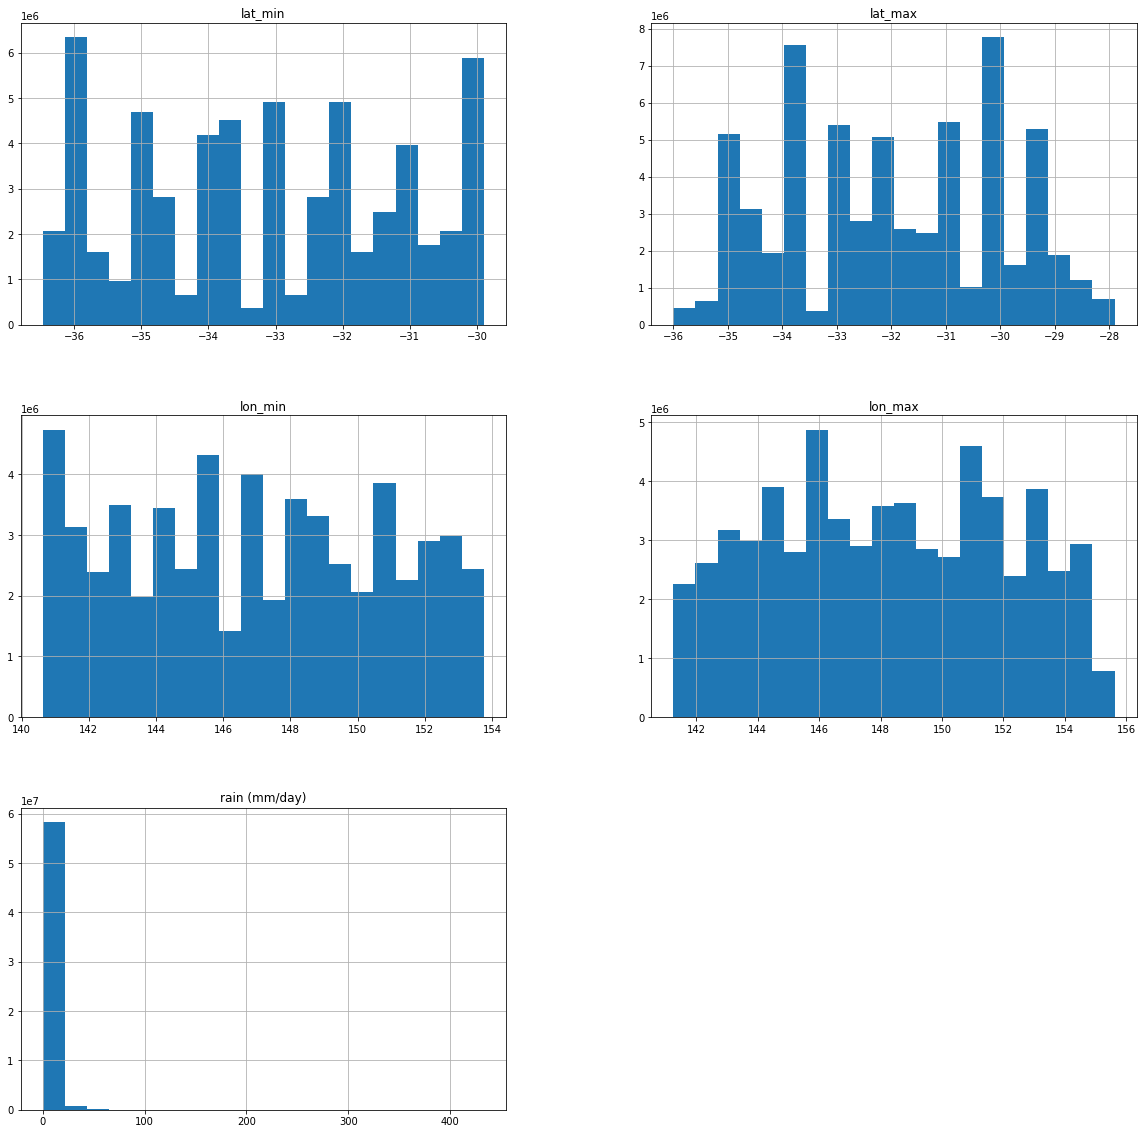

In [18]:
df_dtype.hist(figsize=(20, 20), bins=20);

(array([-10000000.,         0.,  10000000.,  20000000.,  30000000.,
         40000000.,  50000000.,  60000000.,  70000000.]),
 [Text(-10000000.0, 0, '1963-03-25 12:00:00'),
  Text(0.0, 0, '1889-01-01 12:00:00'),
  Text(10000000.0, 0, '1937-05-11 12:00:00'),
  Text(20000000.0, 0, '1987-03-12 12:00:00'),
  Text(30000000.0, 0, '1906-06-02 12:00:00'),
  Text(40000000.0, 0, '1950-10-03 12:00:00'),
  Text(50000000.0, 0, '2006-01-06'),
  Text(60000000.0, 0, '1931-08-22 12:00:00'),
  Text(70000000.0, 0, '')])

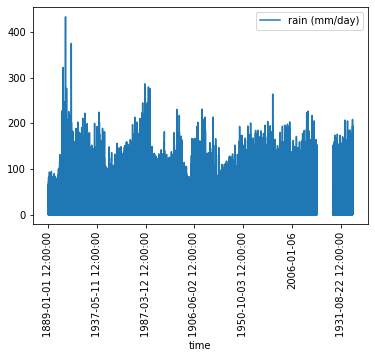

In [19]:
import matplotlib.pyplot as plt

df_dtype.plot.line(y="rain (mm/day)", x="time")
plt.xticks(rotation=90)

# Perform a simple EDA in R

## Transfer the dataframe from python to R

In [20]:
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

In [21]:
%%time
# convert our processed to a pyarrow table
py_table = pa.Table.from_pandas(df_dtype)
# convert pyarrow table to rarrow table
r_table = pyra.converter.py2rpy(py_table)

CPU times: user 6.52 s, sys: 5.45 s, total: 12 s
Wall time: 11.2 s


### Reason of choosing arrow exchange

> As a cross-language development platform for in-memory data, Apache Arrow can greatly improve performances when moving data between Python and R compared to purely Pandas exchange. As we can see, it takes around 10s to process the table. Even in the slowest computer it only takes 49.6s to deal with such a big data frame. And apart from the original CSV, it allows us to directly transform the data frame we have processed in Python to R, which  saves a lot of redundant work. Also, compared to the Parquet file and the Feather file, in addtion to the good performance, Arrow Exchange doesn't need to save extra files, which saves a step and some space. Finally, arrow is well integrated into the dplyr, and many dplyr verbs are supported,so it is very convenient to use Arrow Exchange here.

## EDA

In [22]:
%reload_ext rpy2.ipython

In [23]:
%%R -i r_table
library(dplyr)
head(r_table)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Table
6 rows x 8 columns
$time <string>
$lat_min <float>
$lat_max <float>
$lon_min <float>
$lon_max <float>
$rain (mm/day) <float>
$model <string>
$__index_level_0__ <int64>

See $metadata for additional Schema metadata


In [24]:
%%R -i r_table
r_table |> count(model) |> collect() |> print(n = Inf)

# A tibble: 27 × 2
   model                  n
   <chr>              <int>
 1 NorESM2-LM        919800
 2 ACCESS-CM2       1932840
 3 CMCC-CM2-HR4     3541230
 4 BCC-CSM2-MR      3035340
 5 CMCC-ESM2        3541230
 6 NESM3             966420
 7 TaiESM1          3541230
 8 CMCC-CM2-SR5     3541230
 9 KIOST-ESM        1287720
10 GFDL-ESM4        3219300
11 AWI-ESM-1-1-LR    966420
12 GFDL-CM4         3219300
13 EC-Earth3-Veg-LR 3037320
14 ACCESS-ESM1-5    1610700
15 FGOALS-g3        1287720
16 MPI-ESM1-2-HR    5154240
17 MIROC6           2070900
18 BCC-ESM1          551880
19 SAM0-UNICON      3541153
20 MPI-ESM-1-2-HAM   966420
21 MRI-ESM2-0       3037320
22 MPI-ESM1-2-LR     966420
23 NorESM2-MM       3541230
24 INM-CM5-0        1609650
25 FGOALS-f3-L      3219300
26 CanESM5           551880
27 INM-CM4-8        1609650


In [25]:
%%R
memory.limit(size = 800)
r_df <- r_table |> collect()

In [26]:
%%R
head(r_df)

# A tibble: 6 × 8
  time    lat_min lat_max lon_min lon_max `rain (mm/day)` model `__index_level_…
  <chr>     <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>            <int>
1 1889-0…   -35.4   -33.6    142.    143.        4.24e-13 MPI-…                0
2 1889-0…   -35.4   -33.6    142.    143.        4.22e-13 MPI-…                1
3 1889-0…   -35.4   -33.6    142.    143.        4.50e-13 MPI-…                2
4 1889-0…   -35.4   -33.6    142.    143.        4.25e-13 MPI-…                3
5 1889-0…   -35.4   -33.6    142.    143.        4.27e-13 MPI-…                4
6 1889-0…   -35.4   -33.6    142.    143.        4.20e-13 MPI-…                5


In [27]:
%%R
summary(r_df)

     time              lat_min           lat_max          lon_min       
 Length:62467843    Min.   :-36       Min.   :-36.00   Min.   :141      
 Class :character   1st Qu.:-35       1st Qu.:-33.66   1st Qu.:143      
 Mode  :character   Median :-33       Median :-32.04   Median :147      
                    Mean   :-33       Mean   :-31.98   Mean   :147      
                    3rd Qu.:-31       3rd Qu.:-30.16   3rd Qu.:150      
                    Max.   :-30       Max.   :-27.91   Max.   :154      
                    NA's   :3219300                    NA's   :3219300  
    lon_max      rain (mm/day)        model           __index_level_0__
 Min.   :141.2   Min.   :  0       Length:62467843    Min.   :      0  
 1st Qu.:145.0   1st Qu.:  0       Class :character   1st Qu.: 580528  
 Median :148.1   Median :  0       Mode  :character   Median :1267234  
 Mean   :148.2   Mean   :  2                          Mean   :1479732  
 3rd Qu.:151.3   3rd Qu.:  1                          3r